<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/Tool_Wear_Detection_(Training_EfficientDet)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### *Copyright 2021 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Retrain EfficientDet-Lite detector for the Edge TPU (TF2)
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain EfficientDet for the Edge TPU with TensorFlow Lite Model Maker for **Tool Wear Detection** v1

Retrain the EfficientDet-Lite object detection model (derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html)) using the [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/guide/model_maker), and then compile it to run on the [Coral Edge TPU](https://www.coral.ai/products/). All in about 30 minutes.

Training dataset in the Pascal VOC XML format.

Run the notebook: **Runtime>Run all**

Add owndataset, then continue down to [Load the training data](#scrollTo=H0XM-oIfhgQ7) and follow the instructions there.




## Import the required packages

In [ ]:
!pip install -q tflite-model-maker
!git clone https://github.com/khazzan/toolwearID.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 16.4 MB/s eta 0:

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Load the training data


To train with your own image dataset, follow these steps:

1. Be sure your dataset is annotated in Pascal VOC XML (various tools can help create VOC annotations, such as [LabelImg](https://github.com/tzutalin/labelImg#labelimg)). Then create a ZIP file with all your JPG images and XML files (JPG and XML files can all be in one directory or in separate directories).
2. Click the **Files** tab in the left panel and just drag-drop your ZIP file there to upload it.
3. Use the following drop-down option to set **`use_custom_dataset`** to True.
4. If your dataset is already split into separate directories for training, validation, and testing, also set **`dataset_is_split`** to True. (If your dataset is not split, leave it False and we'll split it below.)
5. Then skip to [Load your own Pascal VOC dataset](#scrollTo=ZljJ25RAnj5x) and follow the rest of the instructions there.




In [ ]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = True #@param ["False", "True"] {type:"raw"}

### Load the CSV dataset



Model Maker requires that we load our dataset using the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/DataLoader) API. So in this case, we'll load it from a CSV file that defines 175 images for training, 25 images for validation, and 25 images for testing.




In [ ]:
if not use_custom_dataset:
  train_data, validation_data, test_data = object_detector.DataLoader.from_csv('wear_ml_use2.csv')

If you want to load your own dataset as a CSV file, you can learn more about the format in [Formatting a training data CSV](https://cloud.google.com/vision/automl/object-detection/docs/csv-format). You can load your CSV either from [Cloud Storage](https://cloud.google.com/storage) (as shown above) or from a local path.

[`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/DataLoader) can also load your dataset in other formats, such as from a set of TFRecord files or from a local directory using the Pascal VOC format (shown below for a custom dataset). 

### Load your own Pascal VOC dataset

To use your custom dataset, you need to modify a few variables here, such as your ZIP filename, your label map, and the path to your images/annotations:

In [ ]:
if use_custom_dataset:

  # The ZIP file you uploaded:
  #!unzip dataset.zip

  # Your labels map as a dictionary (zero is reserved):
  label_map = {1: 'flank_wear'} 

  if dataset_is_split:
    # If your dataset is already split, specify each path:
    train_images_dir = 'toolwearID/split-dataset2/train/images'
    train_annotations_dir = 'toolwearID/split-dataset2/train/annotations'
    val_images_dir = 'toolwearID/split-dataset2/validation/images'
    val_annotations_dir = 'toolwearID/split-dataset2/validation/annotations'
    test_images_dir = 'toolwearID/split-dataset2/test/images'
    test_annotations_dir = 'toolwearID/split-dataset2/test/annotations'
  else:
    # If it's NOT split yet, specify the path to all images and annotations
    images_in = 'dataset/images'
    annotations_in = 'dataset/annotations'
  

Now you're ready to train the model with your custom dataset. But before you run the notebook, you should also skip to the [Export to TensorFlow Lite](#scrollTo=_yB_XMpqGlLs) section and change the `TFLITE_FILENAME` and `LABLES_FILENAME` for your exported files.

Then run the whole notebook by clicking **Runtime > Run all**.

In [ ]:
#@markdown Be sure you run this cell. It's hiding the `split_dataset()` function used in the next code block.

import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [ ]:
# We need to instantiate a separate DataLoader for each split dataset
if use_custom_dataset:
  if dataset_is_split:
    train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)
  else:
    train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                 val_split=0.2, test_split=0.2,
                                                 out_path='split-dataset2')
    train_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(train_dir, 'images'),
        os.path.join(train_dir, 'annotations'), label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(val_dir, 'images'),
        os.path.join(val_dir, 'annotations'), label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(test_dir, 'images'),
        os.path.join(test_dir, 'annotations'), label_map=label_map)
    
  print(f'train count: {len(train_data)}')
  print(f'validation count: {len(validation_data)}')
  print(f'test count: {len(test_data)}')

train count: 188
validation count: 18
test count: 25


## Select the model spec

Model Maker supports the EfficientDet-Lite family of object detection models that are compatible with the Edge TPU. (EfficientDet-Lite is derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html), which offers state-of-the-art accuracy in a small model size). There are several model sizes you can choose from:

|| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|-|--------------------|-----------|---------------|----------------------|
|| EfficientDet-Lite0 | 5.7       | 37.4            | 30.4%               |
|| EfficientDet-Lite1 | 7.6       | 56.3            | 34.3%               |
|| EfficientDet-Lite2 | 10.2      | 104.6           | 36.0%               |
|| EfficientDet-Lite3 | 14.4      | 107.6           | 39.4%               |
| <td colspan=4><br><i>* File size of the compiled Edge TPU models. <br/>** Latency measured on a desktop CPU with a Coral USB Accelerator. <br/>*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.</i></td> |

Beware that the Lite2 and Lite3 models do not fit onto the Edge TPU's onboard memory, so you'll see even greater latency when using those, due to the cost of fetching data from the host system memory. Maybe this extra latency is okay for your application, but if it's not and you require the precision of the larger models, then you can [pipeline the model across multiple Edge TPUs](https://coral.ai/docs/edgetpu/pipeline/) (more about this when we compile the model below).

For this tutorial, we'll use Lite0:

In [ ]:
spec = object_detector.EfficientDetLite0Spec()

The [`EfficientDetLite0Spec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/EfficientDetLite0Spec) constructor also supports several arguments that specify training options, such as the max number of detections (default is 25 for the TF Lite model) and whether to use Cloud TPUs for training. You can also use the constructor to specify the number of training epochs and the batch size, but you can also specify those in the next step.

## Create and train the model

Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training. 

Using Model Maker, we accomplished all of that with [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/create):

In [ ]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=50, 
                               batch_size=10, 
                               train_whole_model=True)

Epoch 1/50
18/18 [==============================] - 65s 843ms/step - det_loss: 1.7891 - cls_loss: 1.1200 - box_loss: 0.0134 - reg_l2_loss: 0.0630 - loss: 1.8521 - learning_rate: 0.0102 - gradient_norm: 2.1453 - val_det_loss: 1.6320 - val_cls_loss: 1.0524 - val_box_loss: 0.0116 - val_reg_l2_loss: 0.0630 - val_loss: 1.6950
Epoch 2/50
18/18 [==============================] - 13s 767ms/step - det_loss: 1.5463 - cls_loss: 0.9055 - box_loss: 0.0128 - reg_l2_loss: 0.0630 - loss: 1.6093 - learning_rate: 0.0125 - gradient_norm: 2.9689 - val_det_loss: 1.4181 - val_cls_loss: 0.8817 - val_box_loss: 0.0107 - val_reg_l2_loss: 0.0630 - val_loss: 1.4811
Epoch 3/50
18/18 [==============================] - 13s 738ms/step - det_loss: 1.3186 - cls_loss: 0.6791 - box_loss: 0.0128 - reg_l2_loss: 0.0630 - loss: 1.3816 - learning_rate: 0.0124 - gradient_norm: 3.8637 - val_det_loss: 1.2416 - val_cls_loss: 0.7292 - val_box_loss: 0.0102 - val_reg_l2_loss: 0.0630 - val_loss: 1.3046
Epoch 4/50
18/18 [=============

## Evaluate the model

Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.

The [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate) method provides output in the style of [COCO evaluation metrics](https://cocodataset.org/#detection-eval):

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 6s 6s/step



{'AP': 0.64868987,
 'AP50': 0.9719472,
 'AP75': 0.78972185,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.6492759,
 'ARmax1': 0.63846153,
 'ARmax10': 0.74615383,
 'ARmax100': 0.74615383,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.74615383,
 'AP_/flank_wear': 0.64868987}

Because the default batch size for [EfficientDetLite models](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/EfficientDetSpec) is 64, this needs only 1 step to go through all 25 images in the salad test set. You can also specify the `batch_size` argument when you call [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate).

## Export to TensorFlow Lite

Next, we'll export the model to the TensorFlow Lite format. By default, the [`export()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#export) method performs [full integer post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization), which is exactly what we need for compatibility with the Edge TPU. (Model Maker uses the same dataset we gave to our model spec as a representative dataset, which is required for full-int quantization.)

We just need to specify the export directory and format. By default, it exports to TF Lite, but we also want a labels file, so we declare both:

In [ ]:
TFLITE_FILENAME = 'efficientdet-lite-wear.tflite'
LABELS_FILENAME = 'wear-labels.txt'

In [ ]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

### Evaluate the TF Lite model

Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [ ]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

25/25 [==============================] - 75s 3s/step



{'AP': 0.62368536,
 'AP50': 0.97834474,
 'AP75': 0.68514854,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.6238019,
 'ARmax1': 0.6423077,
 'ARmax10': 0.6769231,
 'ARmax100': 0.6769231,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.6769231,
 'AP_/flank_wear': 0.62368536}

### Try the TFLite model

Just to be sure of things, let's run the model ourselves with an image from the test set. 

In [ ]:
import random

# If you're using a custom dataset, we take a random image from the test set:
if use_custom_dataset:
  images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
  filenames = os.listdir(os.path.join(images_path))
  random_index = random.randint(0,len(filenames)-1)
  INPUT_IMAGE = os.path.join(images_path, filenames[random_index])
else:
  # Download a test salad image
  INPUT_IMAGE = 'salad-test.jpg'
  DOWNLOAD_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg"
  !wget -q -O $INPUT_IMAGE $DOWNLOAD_URL

To simplify our code, we'll use the [PyCoral API](https://coral.ai/docs/reference/py/):

In [ ]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.0 MB/s eta 0:00:00


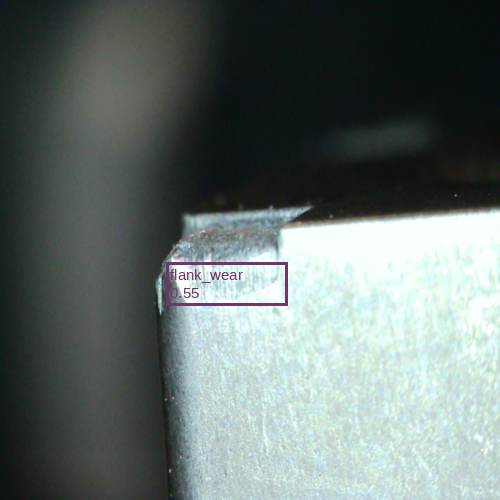

In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

## Compile for the Edge TPU


First we need to download the Edge TPU Compiler:

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  50416      0 --:--:-- --:--:-- --:--:-- 50416
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:9 https://developer.download.nvidia.

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler $TFLITE_FILENAME -d --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Searching for valid delegate with step 1
Try to compile segment with 267 ops
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 4656 ms.

Input model: efficientdet-lite-wear.tflite
Input size: 4.24MiB
Output model: efficientdet-lite-wear_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: efficientdet-lite-wear_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number o

**Beware when using multiple segments:** The Edge TPU Comiler divides the model such that all segments have roughly equal amounts of parameter data, but that does not mean all segments have the same latency. Especially when dividing an SSD model such as EfficientDet, this results in a latency-imbalance between segments, because SSD models have a large post-processing op that actually executes on the CPU, not on the Edge TPU. So although segmenting your model this way is better than running the whole model on just one Edge TPU, we recommend that you segment the EfficientDet-Lite model using our [profiling-based partitioner tool](https://github.com/google-coral/libcoral/tree/master/coral/tools/partitioner#profiling-based-partitioner-for-the-edge-tpu-compiler), which measures each segment's latency on the Edge TPU and then iteratively adjusts the segmentation sizes to provide balanced latency between all segments.

## Download the files

In [ ]:
from google.colab import files

files.download(TFLITE_FILENAME)
files.download(TFLITE_FILENAME.replace('.tflite', '_edgetpu.tflite'))
files.download(LABELS_FILENAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the model on the Edge TPU

You can now run the model with acceleration on the Edge TPU.

First, download an image of a salad on your device with an Edge TPU. For example, you can use the same one we tested above: 

```
wget https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg -O salad.jpg
```

And then make sure you have [installed the PyCoral API](https://coral.ai/software/#pycoral-api).

Now run an inference using [this example code for the PyCoral API](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py). Just clone the GitHub repo and run the example, passing it the model files from this tutorial:

```
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model efficientdet-lite-wear_edgetpu.tflite \
  --labels wear-labels.txt \
  --input image1a.jpg \
  --output image_result.jpg
```


## More resources

* For more information about the Model Maker library used in this tutorial, see the [TensorFlow Lite Model Maker guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).

* For other transfer learning tutorials that are compatible with the Edge TPU, see the [Colab tutorials for Coral](https://github.com/google-coral/tutorials#colab-tutorials-for-coral).

* You can also find more examples that show how to run inference on the Edge TPU at [coral.ai/examples](https://coral.ai/examples/#code-examples/).